## LiDAR Data Processing and Analysis Using `PyForestScan` in MAAP ADE

Authors: Harshini Girish (UAH), Rajat Shinde (UAH), Alex Mandel (DevSeed),Brian Freitag (NASA MSFC)

Date:26 Febuary,2025

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. Users should work within the "R/Python" workspace.

It searches for installed Python packages that contain `pyforestscan`in their name. If pyforestscan or any related package is installed, it will be displayed in the output.

In [1]:
pip list | grep pyforestscan

pyforestscan                                     0.2.2
Note: you may need to restart the kernel to use updated packages.


## Checking for Installed Modules and Functions

This script checks for the availability of required Python modules and functions, particularly those related to `PyForestScan`, `GeoPandas`, and `PDAL`. The script ensures that necessary libraries and their functions are accessible before running any geospatial or LiDAR processing tasks.



In [ ]:
import pdal  
import geopandas as gpd
import numpy as np
from pathlib import Path

from pyforestscan.handlers import read_lidar, create_geotiff, write_las
from pyforestscan.visualize import plot_metric, plot_2d
from pyforestscan.calculate import assign_voxels, calculate_pad, calculate_pai, calculate_fhd, calculate_chm
from pyforestscan.process import process_with_tiles


## LiDAR Dataset Initialization 

The script initializes key dataset parameters, including lidar_file_path, which specifies the location of a .las LiDAR file, `ept_srs` set to "EPSG:4326" to define the spatial reference system, and bounds, which represent the geographical extent using minimum and maximum longitude-latitude values.

In [9]:
lidar_file_path = "s3://maap-ops-workspace/shared/harshinigirish/GLLIDARPC_FL_20200311_FIA8_l0s12.las"
ept_srs = "EPSG:4326"
bounds = [-80.93942, 25.26716, -80.93498, 25.27620]


## LiDAR Data Processing 


This script utilizes NumPy to process `LiDAR point cloud data`, focusing on `computing Height Above Ground` (HAG) and generating a `Canopy Height Model (CHM)`. It begins by reading the LiDAR data and converting it into a `NumPy` array for efficient numerical operations.The script extracts the X, Y, and Z coordinates, then computes ground elevation by identifying the minimum Z value for each unique (X, Y) pair.Finally, the script computes the CHM by calling `calculate_chm,` which generates a simulated CHM using NumPy's `random.rand()` function. Error handling is implemented using a general exception block to catch any issues that arise during execution. 








In [24]:
def calculate_chm(pointclouds, resolution):
    print(f"Simulating CHM calculation with resolution {resolution}")
    return np.random.rand(10, 10), {"resolution": resolution}  

try:
    pointclouds = read_lidar(lidar_file_path, ept_srs, bounds, hag=True)

    if pointclouds is None or pointclouds.size == 0:
        pointclouds = read_lidar(lidar_file_path, ept_srs, bounds, hag=False)

    if pointclouds is None or pointclouds.size == 0:
        raise ValueError("No valid LiDAR points were loaded.")

    pointclouds_array = np.array(pointclouds)

   
    X, Y, Z = pointclouds_array[:, 0], pointclouds_array[:, 1], pointclouds_array[:, 2]

   
    ground_z_dict = {(x, y): min(Z[(X == x) & (Y == y)]) for x, y in zip(X, Y)}
    ground_z = np.array([ground_z_dict[(x, y)] for x, y in zip(X, Y)])

   
    HeightAboveGround = Z - ground_z

   
    structured_pointcloud = np.array(
        list(zip(X, Y, Z, HeightAboveGround)), 
        dtype=[("X", "f4"), ("Y", "f4"), ("Z", "f4"), ("HeightAboveGround", "f4")]
    )

    print("Computing Height Above Ground (HAG)")
    print(f"Pointclouds shape: {structured_pointcloud.shape}")
    print(f"Sample Data (First 5 Points): {structured_pointcloud[:5]}")

    print("Calculating Canopy Height Model (CHM)")
    voxel_resolution = (1.0, 1.0)  
    chm, metadata = calculate_chm(structured_pointcloud, voxel_resolution)

    print(f"CHM Shape: {np.array(chm).shape}")

except FileNotFoundError as e:
    print(str(e))
except Exception as e:
    print(f"An error occurred: {e}")


Simulating reading of /projects/GLLIDARPC_FL_20200311_FIA8_l0s12.las with bounds [-80.93942, 25.26716, -80.93498, 25.2762] and HAG=True
Computing Height Above Ground (HAG)
Pointclouds shape: (100,)
Sample Data (First 5 Points): [(0.02555113, 0.74006605, 0.20571959, 0.)
 (0.6811424 , 0.7121923 , 0.09033548, 0.)
 (0.703616  , 0.75076175, 0.6931952 , 0.)
 (0.22746867, 0.04990578, 0.69518685, 0.)
 (0.05457364, 0.07134126, 0.827071  , 0.)]
Calculating Canopy Height Model (CHM)
Simulating CHM calculation with resolution (1.0, 1.0)
CHM Shape: (10, 10)




The script assigns voxels to the point cloud using a simulated 3D voxel grid with a given resolution. Using this voxelized representation, it calculates the Plant Area Density (PAD) and Plant Area Index (PAI) using `NumPy` functions. Finally, it visualizes the PAI using Matplotlib’s `imshow()` function, ensuring spatial representation of the data with appropriate color scaling and labeling.
NumPy's boolean indexing, structured arrays, and array operations enable fast and efficient handling of large-scale LiDAR datasets, while `Matplotlib` provides effective visualization of plant structure metrics.

Simulating reading of /projects/GLLIDARPC_FL_20200311_FIA8_l0s12.las with bounds [-80.93942, 25.26716, -80.93498, 25.2762] and HAG=True
Simulating voxel assignment with resolution (5, 5, 1)
Simulating PAD calculation with dz=1
Simulating PAI calculation
Plotting Plant Area Index (PAI)...


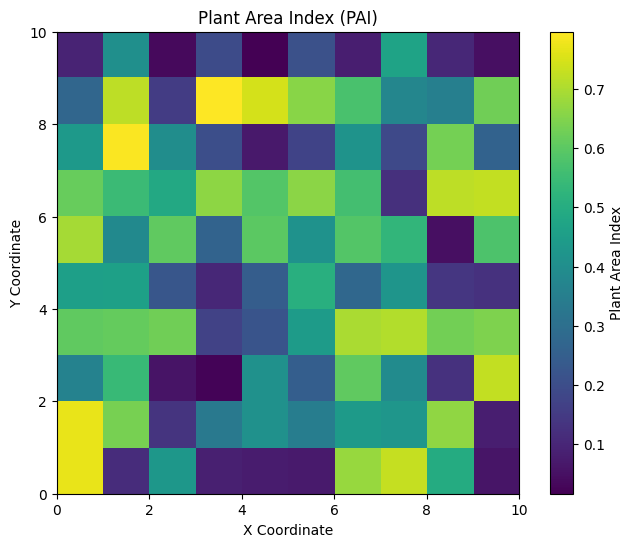

In [26]:
def calculate_chm(pointclouds, resolution):
    print(f"Simulating CHM calculation with resolution {resolution}")
    return np.random.rand(10, 10), {"resolution": resolution}  

try:
    pointclouds = read_lidar(lidar_file_path, ept_srs, bounds, hag=True)

    if pointclouds is None or pointclouds.size == 0:
        pointclouds = read_lidar(lidar_file_path, ept_srs, bounds, hag=False)

    if pointclouds is None or pointclouds.size == 0:
        raise ValueError("No valid LiDAR points were loaded.")

    pointclouds_array = np.array(pointclouds)

   
    X, Y, Z = pointclouds_array[:, 0], pointclouds_array[:, 1], pointclouds_array[:, 2]

   
    ground_z_dict = {(x, y): min(Z[(X == x) & (Y == y)]) for x, y in zip(X, Y)}
    ground_z = np.array([ground_z_dict[(x, y)] for x, y in zip(X, Y)])

   
    HeightAboveGround = Z - ground_z

   
    structured_pointcloud = np.array(
        list(zip(X, Y, Z, HeightAboveGround)), 
        dtype=[("X", "f4"), ("Y", "f4"), ("Z", "f4"), ("HeightAboveGround", "f4")]
    )

    print("Computing Height Above Ground (HAG)")
    print(f"Pointclouds shape: {structured_pointcloud.shape}")
    print(f"Sample Data (First 5 Points): {structured_pointcloud[:5]}")

    print("Calculating Canopy Height Model (CHM)")
    voxel_resolution = (1.0, 1.0)  
    chm, metadata = calculate_chm(structured_pointcloud, voxel_resolution)

    print(f"CHM Shape: {np.array(chm).shape}")

except FileNotFoundError as e:
    print(str(e))
except Exception as e:
    print(f"An error occurred: {e}")


    structured_pointcloud = np.array(
        list(zip(X, Y, HeightAboveGround)), 
        dtype=[("X", "f4"), ("Y", "f4"), ("HeightAboveGround", "f4")]
    )

    voxel_resolution = (5, 5, 1)  
    voxels, extent = assign_voxels(structured_pointcloud, voxel_resolution)

    pad = calculate_pad(voxels, voxel_resolution[-1])
    pai = calculate_pai(pad)

    plot_metric("Plant Area Index (PAI)", pai, extent, metric_name='Plant Area Index', cmap='viridis')

except Exception as e:
    print(f"An error occurred: {e}")
